In [2]:
from datasets.load import load_images
import matplotlib.patches as patches
import matplotlib.pyplot as plt
import numpy as np
import pickle
import time
import cv2

plt.rcParams["figure.figsize"] = (15.0, 12.0)  # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
# plt.rcParams['image.cmap'] = 'gray'

# for auto-reloading extenrnal modules
%load_ext autoreload
%autoreload 2

### Load training and testing data from disk (images saved as arrays during preprocessing)

In [3]:
with open("cache/training/waldo.pkl", "rb") as f:
    pos_waldo = pickle.load(f)
with open("cache/training/wenda.pkl", "rb") as f:
    pos_wenda = pickle.load(f)
with open("cache/training/wizard.pkl", "rb") as f:
    pos_wizard = pickle.load(f)
with open("cache/training/neg_samples.pkl", "rb") as f:
    neg_samples = pickle.load(f)

with open("cache/testing/waldo.pkl", "rb") as f:
    pos_waldo_test = pickle.load(f)
with open("cache/testing/wenda.pkl", "rb") as f:
    pos_wenda_test = pickle.load(f)
with open("cache/testing/wizard.pkl", "rb") as f:
    pos_wizard_test = pickle.load(f)

# Training cascade classifier

### Generate .dat file describing positive samples and save cropped samples as actual .jpg files

In [4]:
# example entry in .dat file: img/img1.jpg  1  140 100 45 45

with open('cache/training/waldo.info', 'w') as f:
    for idx, img in enumerate(pos_waldo):
        image_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        cv2.imwrite('cache/training/pos/waldo_{}.jpg'.format(idx), image_rgb)
        f.write('{} {} {} {} {} {}\n'.format('pos/waldo_{}.jpg'.format(idx), 1, 0, 0, img.shape[1], img.shape[0]))

with open('cache/training/wenda.info', 'w') as f:
    for idx, img in enumerate(pos_wenda):
        image_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        cv2.imwrite('cache/training/pos/wenda_{}.jpg'.format(idx), image_rgb)
        f.write('{} {} {} {} {} {}\n'.format('pos/wenda_{}.jpg'.format(idx), 1, 0, 0, img.shape[1], img.shape[0]))

with open('cache/training/wizard.info', 'w') as f:
    for idx, img in enumerate(pos_wizard):
        image_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        cv2.imwrite('cache/training/pos/wizard_{}.jpg'.format(idx), image_rgb)
        f.write('{} {} {} {} {} {}\n'.format('pos/wizard_{}.jpg'.format(idx), 1, 0, 0, img.shape[1], img.shape[0]))

# save the cropped samples from images hold out for testing as .jpg files to disk as well

for idx, img in enumerate(pos_waldo_test):
        image_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        cv2.imwrite('cache/testing/pos/waldo_{}.jpg'.format(idx), image_rgb)
for idx, img in enumerate(pos_wenda_test):
        image_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        cv2.imwrite('cache/testing/pos/wenda_{}.jpg'.format(idx), image_rgb)
for idx, img in enumerate(pos_wizard_test):
        image_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        cv2.imwrite('cache/testing/pos/wizard_{}.jpg'.format(idx), image_rgb)

### Generate bg.txt file describing negative samples and save negative samples as actual .jpg files

In [5]:
with open('cache/training/bg.txt', 'w') as f:
    for idx, img in enumerate(neg_samples):
        image_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        cv2.imwrite('cache/training/neg/negative_{}.jpg'.format(idx), image_rgb)
        f.write('neg/negative_{}.jpg\n'.format(idx))

### Generate .vec file for positive Waldo samples

In [6]:
# run this as shell commands:
# !opencv_createsamples -info waldo.info -num 124 -w 128 -h 128 -vec waldo.vec

### Train classifier using command line

In [7]:
# data1 waldo classifier trained via following command
# opencv_traincascade -data data -vec waldo.vec -bg bg.txt -numPos 124 -numNeg 250 -numStages 5
#  -precalcValBufSize 6144 -precalcIdxBufSize 6144 -acceptanceRatioBreakValue 10e-5 -featureType LBP -w 128 -h 128 
#  -weightTrimRate 0.95 -maxDepth 1

# data2 waldo classifier trained via following command
# opencv_traincascade -data data -vec waldo.vec -bg bg.txt -numPos 115 -numNeg 250 -numStages 10
#  -precalcValBufSize 7000 -precalcIdxBufSize 7000 -acceptanceRatioBreakValue 10e-5 -featureType LBP -w 128 -h 128 
#  -weightTrimRate 0.95 -maxDepth 1

# data3 waldo classifier trained via following command
# opencv_traincascade -data data -vec waldo.vec -bg bg.txt -numPos 124 -numNeg 250 -numStages 10
#  -precalcValBufSize 7000 -precalcIdxBufSize 7000 -acceptanceRatioBreakValue 10e-5 -featureType LBP -w 48 -h 48 
#  -weightTrimRate 0.95 -maxDepth 1

# Test classifier

### Load test data from disk and save test images as .jpg

In [8]:
with open("cache/testing/waldo.pkl", "rb") as f:
    waldo_test = pickle.load(f)
    
with open("cache/testing/neg_samples.pkl", "rb") as f:
    neg_test = pickle.load(f)

# The following generates perfectly cropped positive Waldos only
for idx, img in enumerate(waldo_test):
    image_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    cv2.imwrite('cache/testing/pos/waldo_{}.jpg'.format(idx), image_rgb)
    
# The following generates 128x128 negatives only
for idx, img in enumerate(neg_test):
    image_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    cv2.imwrite('cache/testing/neg/negative_{}.jpg'.format(idx), image_rgb)

In [9]:
cascPath = 'cache/training/data_2/cascade.xml'

waldoCascade = cv2.CascadeClassifier(cascPath)

def find_waldo(image):
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    waldos = waldoCascade.detectMultiScale(
        gray,
        scaleFactor=1.1,
        minNeighbors=0, # should be like ~5 but currently there's no frame around a true sample so it must be 0
        minSize=(128, 128),
        flags=cv2.CASCADE_SCALE_IMAGE
    )
    return waldos

### Run classifier on ground truth positive test images (scaled to exact fit dimensions of classifier)

/Users/daviddrews/anaconda3/envs/CS4243/lib/python3.7/site-packages/ipykernel_launcher.py:10: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  # Remove the CWD from sys.path while we load stuff.


test data: 5 TP. 8 FN.


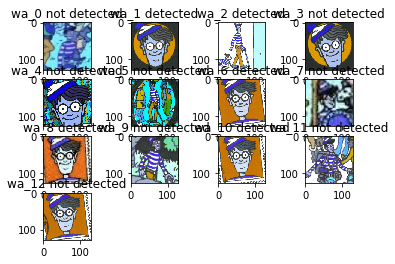

In [10]:
waldo_test_bbbs = []
not_detected = 0

for idx, img in enumerate(waldo_test[:16]):
    waldo_bb = find_waldo(img)
    waldo_test_bbbs.append(waldo_bb)
    
    ax = plt.subplot(4,4,idx +1)
    plt.imshow(img)
    if waldo_bb == ():
        plt.title('wa_{} not detected'.format(idx))
        not_detected += 1
    else:
        plt.title('wa_{} detected'.format(idx))

print("test data: {} TP. {} FN.".format(len(waldo_test_bbbs)-not_detected, not_detected))
plt.show()

### Run classifier on ground truth positive test images (scaled to exact fit dimensions of classifier)

/Users/daviddrews/anaconda3/envs/CS4243/lib/python3.7/site-packages/ipykernel_launcher.py:10: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  # Remove the CWD from sys.path while we load stuff.


train data: 9 TP. 7 FN.


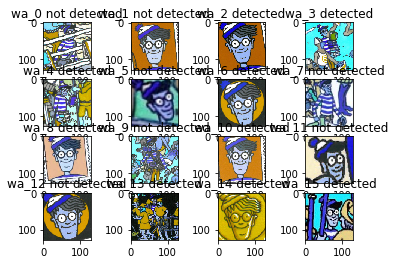

In [11]:
waldo_train_bbs = []
not_detected = 0

for idx, img in enumerate(pos_waldo[:16]):
    waldo_bb = find_waldo(img)
    waldo_train_bbs.append(waldo_bb)
    
    ax = plt.subplot(4,4,idx +1)
    plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    if waldo_bb == ():
        plt.title('wa_{} not detected'.format(idx))
        not_detected += 1
    else:
        plt.title('wa_{} detected'.format(idx))

print("train data: {} TP. {} FN.".format(len(waldo_train_bbs)-not_detected, not_detected))
plt.show()

### Run classifier on ground truth negative test images (scaled to exact fit dimensions of classifier)

test data: 0 FP. 16 TN.


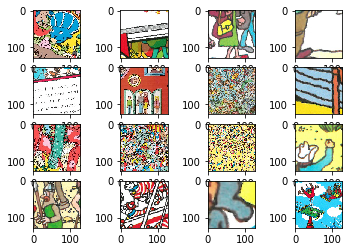

In [12]:
negative_test_bbs = []
not_detected = 0

for idx, img in enumerate(neg_test[:16]):
    waldo_bb = find_waldo(img)
    negative_test_bbs.append(waldo_bb)
    
    ax = plt.subplot(4,4,idx +1)
    plt.imshow(img)
    if waldo_bb == ():
        not_detected += 1
    else:
        plt.title('waldo detected')

print("test data: {} FP. {} TN.".format(len(negative_test_bbs)-not_detected, not_detected))
plt.show()

### Check evaluation time of Waldo classifier for all negatives

In [13]:
print("amount of true negative samples: {}\n".format(len(neg_test)))
not_detected = 0
start_time = time.time()

for idx, img in enumerate(neg_test):
    if find_waldo(img) == ():
        not_detected += 1
print("test data: {} FP. {} TN.".format(len(neg_test)-not_detected, not_detected))
print("calculation took {} ms.".format(int(round((time.time()-start_time)*1000))))

amount of true negative samples: 2930

test data: 61 FP. 2869 TN.
calculation took 76 ms.


/Users/daviddrews/anaconda3/envs/CS4243/lib/python3.7/site-packages/ipykernel_launcher.py:6: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  


## Run classifier on normal test images

In [14]:
# code does not work

def draw_bbox(ax, name, box, col='r'):
    r = patches.Rectangle((box[0], box[1]), 
                          box[2] - box[0],
                          box[3] - box[1],
                          linewidth=3,
                          edgecolor=col,
                          facecolor='none')
    ax.add_patch(r)
    ax.text(box[0], box[1], name, bbox={'facecolor': col, 'linewidth': 0})

def draw_annotation(ax, classes):
    colors = plt.get_cmap('tab10')
    for idx, cl in enumerate(classes):
        col = colors(idx)
        for box in cl['bounds']:
            draw_bbox(ax, cl['name'], box, col)

### Load test images

In [16]:
from datasets.load import _read_sample
import os

cat_name = 'val'
dataset_base = 'datasets'
image_set = os.path.join(dataset_base, "ImageSets/" + cat_name + ".txt")
assert os.path.exists(image_set)

samples = []

with open(image_set, "r") as f:
    for l in f.readlines():
        file = l.strip("\n")
        samples.append(_read_sample(dataset_base, file))

### Show test images

{'name': 'wenda', 'bounds': [{'x1': 912, 'y1': 804, 'x2': 932, 'y2': 836}]}
{'name': 'waldo', 'bounds': [{'x1': 292, 'y1': 427, 'x2': 311, 'y2': 475}]}


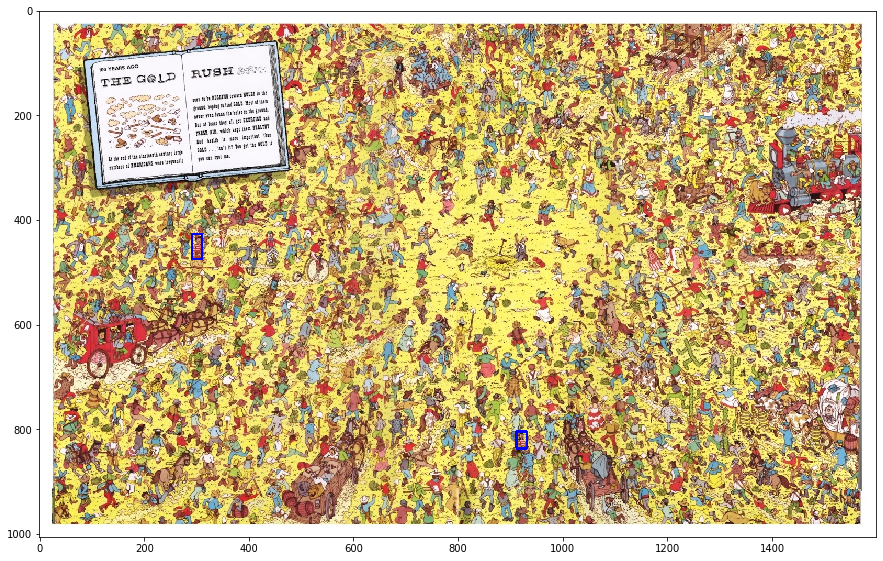

In [22]:
for sample in samples[:1]:
    img = sample['img']
    for cl in sample['classes']:
        print(cl)
        for box in cl['bounds']:
            p1 = (box['x1'], box['y1'])
            p2 = (box['x2'], box['y2'])
            red = (0, 0, 255)
            cv2.rectangle(img, p1, p2, red, 3)
    #cv2.imshow(sample['filename'], img)
    plt.imshow(img)

In [67]:
for sample in samples:
    print("\nfile {}".format(sample['filename']))
    for cl in sample['classes']:
        print("{} located at {}".format(cl['name'], cl['bounds']))
    
    waldos = find_waldo(sample['img'])
    print("{} waldos found".format(len(waldo)))
    
    """if waldo != ():
        fig, ax = plt.subplots(1)
        ax.imshow(waldo)
        plt.show()"""


file 003.jpg
class wenda located at [{'x1': 912, 'y1': 804, 'x2': 932, 'y2': 836}]
class waldo located at [{'x1': 292, 'y1': 427, 'x2': 311, 'y2': 475}]
3051091 waldos found

file 018.jpg
class waldo located at [{'x1': 1933, 'y1': 668, 'x2': 2295, 'y2': 1076}, {'x1': 2479, 'y1': 3945, 'x2': 2802, 'y2': 4630}]
class wenda located at [{'x1': 1856, 'y1': 3961, 'x2': 2148, 'y2': 4645}, {'x1': 7029, 'y1': 4378, 'x2': 7216, 'y2': 4648}]
class wizard located at [{'x1': 1372, 'y1': 3953, 'x2': 1787, 'y2': 4607}]
3051091 waldos found

file 036.jpg
class waldo located at [{'x1': 614, 'y1': 488, 'x2': 874, 'y2': 748}]
3051091 waldos found

file 043.jpg
class waldo located at [{'x1': 718, 'y1': 353, 'x2': 2402, 'y2': 1999}, {'x1': 3779, 'y1': 6068, 'x2': 4010, 'y2': 6753}]
3051091 waldos found

file 038.jpg
class waldo located at [{'x1': 2425, 'y1': 88, 'x2': 2879, 'y2': 596}]
class wizard located at [{'x1': 318, 'y1': 5073, 'x2': 772, 'y2': 5473}]
class wenda located at [{'x1': 5518, 'y1': 2519,

### Visualise cascade classifiers using command line

In [ ]:
# !opencv_visualisation --image=/cache/testing/pos/waldo_0.jpg --model=/cache/training/data_1/cascade.xml --data=/cache/training/visualisation